[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/guiwitz/DSL_CV2_PyTorch/blob/main/notebooks/02-Simple_NN.ipynb)
# Neural networks with PyTorch

Most of the time, one uses pre-made neural network model architectures. However it is important to understand how a network is built so that one can modify it, access specific parts of it, or understand how training works. This is what we do here with simple linear layers before looking at standard layers used for computer vision. But first:

## What is a Neural Network?

These networks take their name from early models that tried to "reproduce" what happens with neurons in our brains. Neurons are specialized cell types that are connected to each other via axons as shown below (left, https://commons.wikimedia.org/wiki/File:Two_neurons_connected.svg):

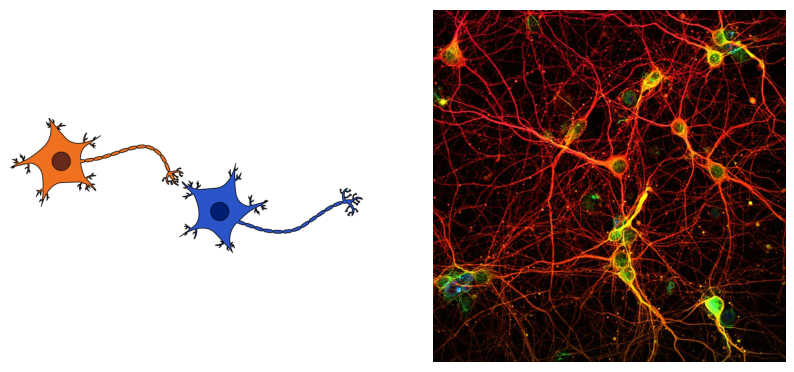

In [1]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1,2, figsize=(10,5))
ax[0].imshow(plt.imread("../images/Two_neurons_connected.png"))
ax[1].imshow(plt.imread("../images/neurons.jpg"))
ax[0].set_axis_off()
ax[1].set_axis_off()

Neurons communicate via electrical signals and the strength of the connection between two neurons can change with learning: if e.g. two neurons need to communicate often the connection becomes stronger. These neurons are not just connected as pairs but form very large networks of interconnected cells as shown above (right, https://commons.wikimedia.org/wiki/File:Neuronal_web.tif, [CC-BY-4.0](https://creativecommons.org/licenses/by/4.0/deed.en)).

Computational neural networks try to reproduce this scheme: they are composed of **nodes** (neurons, $x_1, x_2 \dots$ below) linked to each others by connectors (axons) of a certain **weight** (connection strength, $w_1, w_2, \dots$ below). Very often they are represented as shown below.

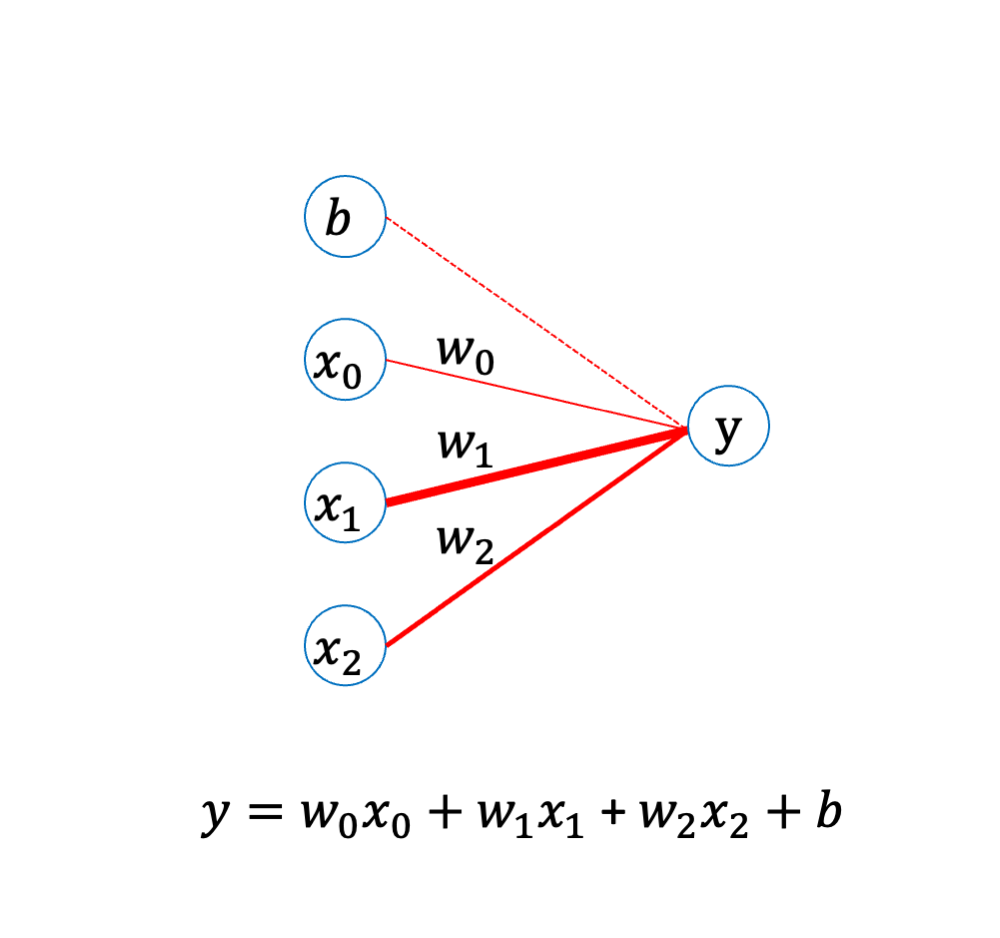

In [2]:
from IPython.display import Image, display
Image('../images/networks1.png', width=500)

Here $x_0, x_1, x_2$ are inputs whose combination through the weights $w_i$ generates the output $y$. The above neural network is the simplest you can create and actually represents **a linear regression model**. Typically in such a case one has measurements $x_i$ (features) and $y$ (target) and one wants to optimize the values of the weights $w_i$ so that one can predict targets with features.

## Layers

The series $x_0, x_1, x_2$ that we have in the above drawing represents a sort of "unit" in a neural network and is called a **layer**. This is just the first layer of a network and we will have more, so let's index it starting with zero:

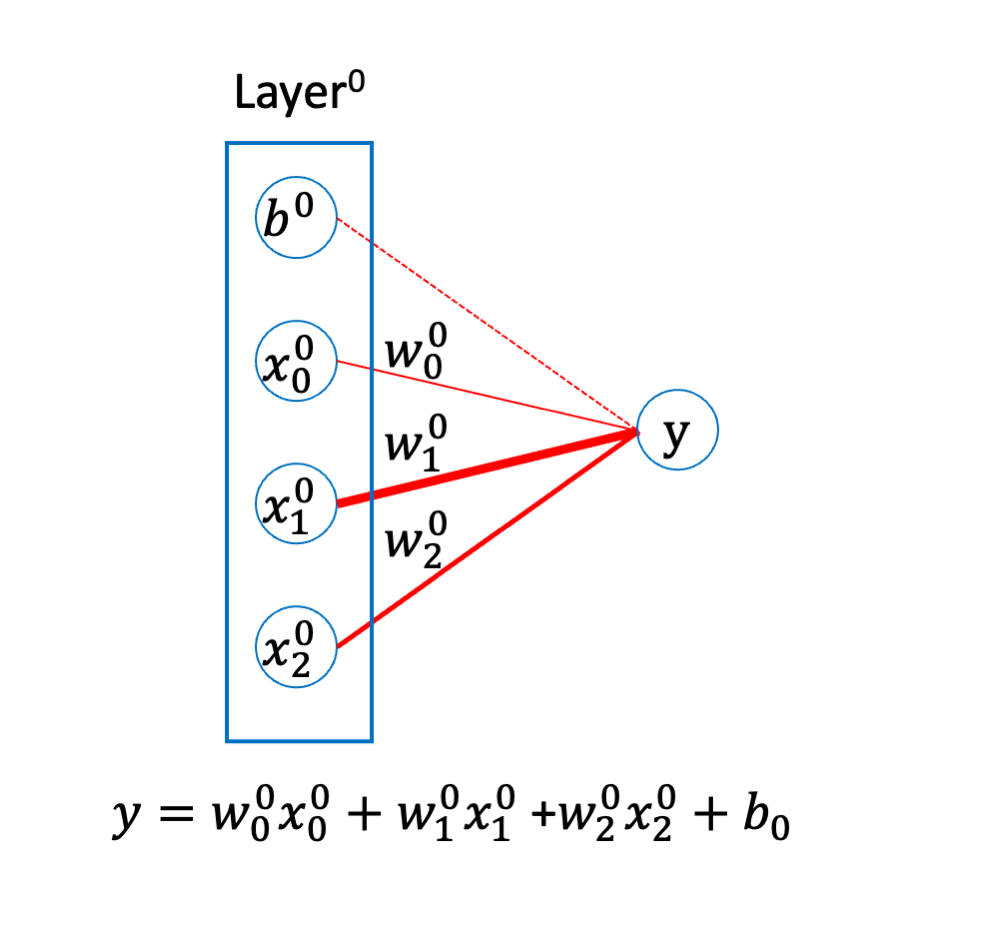

In [11]:
Image('../images/networks2.png', width=500)

In a network, multiple such layers are stacked in sequence(**deep** learning), each layer's output being, the next layer's input. The last layer then predicts the target $y$. In such a case, the intermediate ("hidden") layers produce multiple output that are recombined in the next layer as shown here:

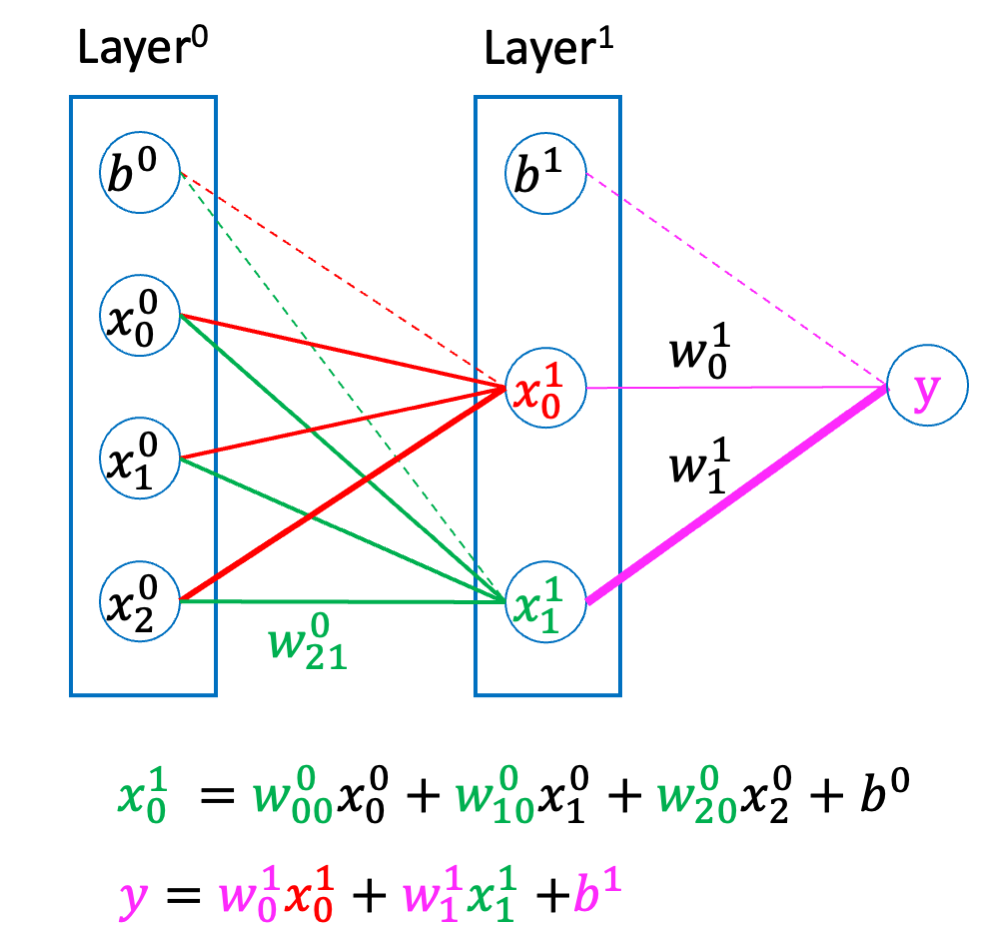

In [12]:
Image('../images/networks3.png', width=500)

Note that the model above is composed only of linear layers. More complex layers are used in deep learning, but the fundamental idea is the same: outputs of a layer are recombined in the next layer.

## Layers in PyTorch: ```torch.nn```

In PyTorch, each layer of a network is a **Module**, and a series of common layer or modules are found in ```torch.nn```. Each module has a certain number and shape of inputs and outputs. As the name indicates, these modules are really *modular* in the sense that they are independent parts of networks that can be combined together. Once two or more modules are stacked together, they again form a module with inputs and outputs. Hence a complete deep learning model is also just a module.

Let's see how such a simple module works using the type of linear layer described above:

In [3]:
import torch
torch.manual_seed(42);
from torch import nn

We create now a linear layer with input size 5 and output size 10:

In [4]:
lin_layer = nn.Linear(in_features=5, out_features=10)

This single layer already has parameters:

In [5]:
list(lin_layer.parameters())

[Parameter containing:
 tensor([[ 0.3419,  0.3712, -0.1048,  0.4108, -0.0980],
         [ 0.0902, -0.2177,  0.2626,  0.3942, -0.3281],
         [ 0.3887,  0.0837,  0.3304,  0.0606,  0.2156],
         [-0.0631,  0.3448,  0.0661, -0.2088,  0.1140],
         [-0.2060, -0.0524, -0.1816,  0.2967, -0.3530],
         [-0.2062, -0.1263, -0.2689,  0.0422, -0.4417],
         [ 0.4039, -0.3799,  0.3453,  0.0744, -0.1452],
         [ 0.2764,  0.0697,  0.3613,  0.0489, -0.1410],
         [ 0.1202, -0.1213,  0.1882,  0.3993,  0.2585],
         [-0.1955,  0.2582,  0.0800,  0.2271, -0.2726]], requires_grad=True),
 Parameter containing:
 tensor([-0.4427, -0.1728, -0.3430,  0.3670,  0.1288,  0.1852,  0.1414, -0.0078,
          0.3500, -0.3178], requires_grad=True)]

We see that we have indeed a 5x10 matrix plus the bias term of size 10. When we later assemble multiple modules, we will see the same time of output but with many more parameters.

Note also that the tensors have the mention ```requires_grad=True``` meaning that they will be part of the optimization process of training that we will do later.

## Passing an input

Our layer takes a vector as an input so let's create a tensor of size 5:

In [6]:
mytensor = torch.randint(0,100,(5,))
mytensor

tensor([66, 30, 40, 60, 70])

No we we pass it to ```lin_layer```:

In [7]:
lin_layer(mytensor)

RuntimeError: expected scalar type Long but found Float

In [8]:
mytensor.dtype

torch.int64

In [9]:
lin_layer.weight.dtype

torch.float32

The error can be a bit misleading. The problem here is that the weights in the layer are defined by default as ```float32```. Hence the input should match this but we passed a 64 bits integer which creates a conflict. Let's adjust the type of our tensor. We can either modify the tensor:

In [10]:
mytensor_float = mytensor.float()

Now we finally have the right object to path through our network:

In [11]:
output = lin_layer(mytensor_float)
output

tensor([ 46.8583,  10.4452,  59.7683,   4.6391, -29.2204, -56.3530,  23.5120,
         27.8365,  54.2238,  -7.7297], grad_fn=<AddBackward0>)

In [12]:
output.shape

torch.Size([10])

We see that the ouput has as expected as size of 10! Now we could add a new layer which takes these 10 outputs as inputs and for example outputs 3 values:

In [13]:
lin_layer2 = nn.Linear(10,3)
output = lin_layer2(output)

In [14]:
output.size()

torch.Size([3])

## Sequential model

We don't want to manually pass outputs of one layer as inputs to the second one. To put multiple layers (modules) together we can for example use the ```Sequential``` model of PyTorch:

In [15]:
model = nn.Sequential(lin_layer, lin_layer2)

Now we can again pass our input and verify that the output has still size 3:

In [16]:
out = model(mytensor_float)
out.shape

torch.Size([3])

## Activation

For the moment our model is purely linear. We can stack as many layers as we want: as all of them do linear combinations of inputs, the whole model is still linear. As deep learning typically tries to model complex, non-linear effects, it this therefore crucial to add non-linearities in the system. This is typically done by using **activation** functions that take all the outputs of a given layer and apply a non-linear function to them:

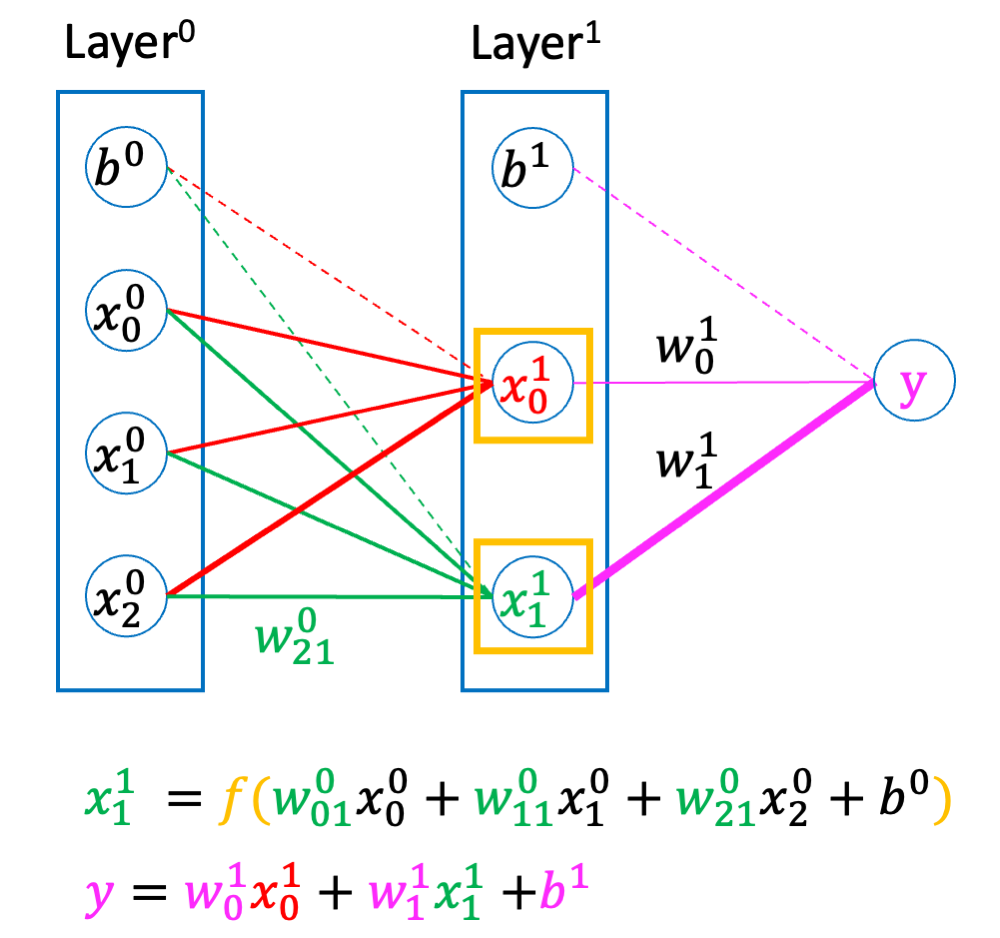

In [17]:
Image('../images/networks4.png', width=500)

The activation function $f$ can take many forms but *has to be non-linear*. Common examples are for example the sigmoid function or the rectified linear unit or ReLU which looks like this:

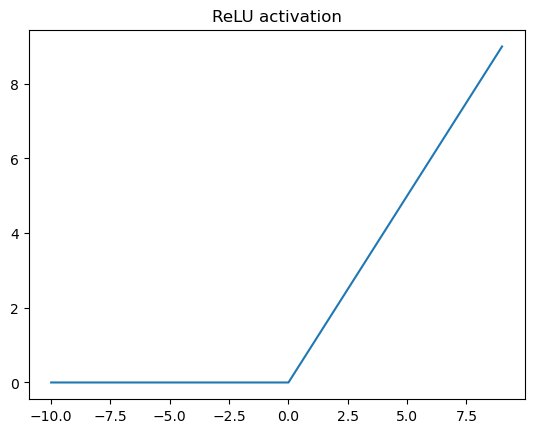

In [18]:
from torch.nn.functional import relu
fig, ax = plt.subplots()
ax.plot(torch.arange(-10,10), relu(torch.arange(-10,10)));
ax.set_title('ReLU activation');

The ReLU function takes an number $x$ in and gives 0 if $x<0$ and $x$ if $x>0$. It's a very simple non-linear function but sufficient to create complex models in a NN.

Depending how we define our model, activation functions can be actual functions from the ```torch.nn.functional``` module or layers. For example in functional form:

In [19]:
import torch.nn.functional as F

In [20]:
output = lin_layer(mytensor_float)
output

tensor([ 46.8583,  10.4452,  59.7683,   4.6391, -29.2204, -56.3530,  23.5120,
         27.8365,  54.2238,  -7.7297], grad_fn=<AddBackward0>)

In [21]:
output_activated = F.relu(output)
output_activated

tensor([46.8583, 10.4452, 59.7683,  4.6391,  0.0000,  0.0000, 23.5120, 27.8365,
        54.2238,  0.0000], grad_fn=<ReluBackward0>)

Or as layer:

In [22]:
relu_layer = nn.ReLU()

In [23]:
relu_layer(output)

tensor([46.8583, 10.4452, 59.7683,  4.6391,  0.0000,  0.0000, 23.5120, 27.8365,
        54.2238,  0.0000], grad_fn=<ReluBackward0>)

In this case, the layer can be added to the ```Sequential``` model:

In [24]:
model = nn.Sequential(lin_layer, nn.ReLU(), lin_layer2)

## Model as a module

Until now we have defined our model as a sequence of layers added to the ```Sequential``` model. For standard models this is fine, but modern networks are often composed of multiple sub-networks whose outputs are combined etc. which then requires a more detailed model definition. In PyTorch this is done by sub-classing the ```nn.Module``` object, which typically looks like this:

In [25]:
class Mynetwork(nn.Module):
    def __init__(self, myparameter1, myparameter2):
        super(Mynetwork, self).__init__()
        
        # define e.g. layers here e.g.
        self.layer1 = nn.Linear(myparameter1, 5)
        self.layer2 = nn.Linear(5, myparameter2)

    def forward(self, x):
        
        # define the sequence of operations in the network including e.g. activations
        x = F.relu(self.layer1(x))
        x = self.layer2(x)
        
        return x

Above, we have defined a simple network that is defined by two parameters, ```myparameter1, myparameter2``` for the initial input size and desired final output size. It is composed of two linear layers and ReLU unit. The model definition is split into two parts:
1. Define all layers of the model in the ```__init__``` function, here two linear layers.
2. Combine the layers defined above in the correct sequence and add activations as functions in the ```forward``` function. By definition ```forward``` takes an input ```x``` (e.g. an image to classify), passes it through the network and outputs the result. Therefore in principle we could instantiate a model and use it like this:

```
mymodel = Mynetwork(9,3)
mymodel.forward(myinput)
```

However, ```nn.Module``` has a ```__call__``` attribute that allows us to use the class as a function like this:

```
mymodel = Mynetwork(9,3)
mymodel(myinput)
```

This is actually **how a module should be properly used** in order to exploit all capabilities offered in PyTorch.

Let's now try this out. We instantiate the model:

In [26]:
mymodel = Mynetwork(9,3)

Just like for the single linear layer before, we can have a look at all parameters:

In [27]:
list(mymodel.parameters())

[Parameter containing:
 tensor([[-0.1182, -0.3225, -0.1909,  0.0833, -0.0440, -0.2420,  0.0078, -0.2277,
          -0.2828],
         [-0.1836, -0.2917, -0.2122,  0.3332,  0.0630,  0.1027, -0.3109, -0.2189,
          -0.1110],
         [ 0.0521, -0.2933, -0.1436, -0.1996,  0.0009, -0.1240, -0.0231, -0.2259,
          -0.2288],
         [-0.1945, -0.1141, -0.2631,  0.2795, -0.0662,  0.2868,  0.1039, -0.2823,
           0.2307],
         [-0.0917, -0.1278, -0.2767, -0.3314,  0.0954, -0.0728,  0.1298, -0.2736,
           0.2475]], requires_grad=True),
 Parameter containing:
 tensor([-0.2447, -0.0576,  0.0696,  0.1721,  0.2691], requires_grad=True),
 Parameter containing:
 tensor([[ 0.4074, -0.3546,  0.1125, -0.1924, -0.0490],
         [-0.3347,  0.4073, -0.3282,  0.2390,  0.1572],
         [ 0.1453, -0.2418,  0.4065,  0.0983,  0.0575]], requires_grad=True),
 Parameter containing:
 tensor([-0.3941,  0.1877, -0.0671], requires_grad=True)]

The output is the same, only now we see all parameters from all layers, not just a single one. We can also look at the modules contained in our network:

In [28]:
list(mymodel.modules())

[Mynetwork(
   (layer1): Linear(in_features=9, out_features=5, bias=True)
   (layer2): Linear(in_features=5, out_features=3, bias=True)
 ),
 Linear(in_features=9, out_features=5, bias=True),
 Linear(in_features=5, out_features=3, bias=True)]

We see some repeats because we see here modules at all levels. E.g. each linear layer is a module but our entire network is a module as well.

We can also just find all modules contained in our main module and recover its name and function:

In [29]:
for name, module in mymodel.named_children():
    print(f'name: {name} module: {module}')

name: layer1 module: Linear(in_features=9, out_features=5, bias=True)
name: layer2 module: Linear(in_features=5, out_features=3, bias=True)


We can also obtain a dictionary of all layers with their weights:

In [30]:
mymodel.state_dict()

OrderedDict([('layer1.weight',
              tensor([[-0.1182, -0.3225, -0.1909,  0.0833, -0.0440, -0.2420,  0.0078, -0.2277,
                       -0.2828],
                      [-0.1836, -0.2917, -0.2122,  0.3332,  0.0630,  0.1027, -0.3109, -0.2189,
                       -0.1110],
                      [ 0.0521, -0.2933, -0.1436, -0.1996,  0.0009, -0.1240, -0.0231, -0.2259,
                       -0.2288],
                      [-0.1945, -0.1141, -0.2631,  0.2795, -0.0662,  0.2868,  0.1039, -0.2823,
                        0.2307],
                      [-0.0917, -0.1278, -0.2767, -0.3314,  0.0954, -0.0728,  0.1298, -0.2736,
                        0.2475]])),
             ('layer1.bias',
              tensor([-0.2447, -0.0576,  0.0696,  0.1721,  0.2691])),
             ('layer2.weight',
              tensor([[ 0.4074, -0.3546,  0.1125, -0.1924, -0.0490],
                      [-0.3347,  0.4073, -0.3282,  0.2390,  0.1572],
                      [ 0.1453, -0.2418,  0.4065,  0.0983,

Finally we can pass an input through our network. It takes an input of size 9:

In [31]:
my_input = torch.randn((9,))

In [32]:
output = mymodel(my_input)

In [34]:
output

tensor([-0.3941,  0.1877, -0.0671], grad_fn=<AddBackward0>)

## Saving and loading a model

Our next goal will be to train our network (see next chapter). At some point during or after training we will want to save both our model and its weights. This can be done in two ways.

### Save full model

First, we can save the entire model so that it can be simply reloaded. This is practical when developing but can lead to problems when moving saved models between computers. First we save our model (create a ````models```` folder in your directory if needed):

In [36]:
# set path containing data folder or use default for Colab (/gdrive/My Drive)
local_folder = "../"
import urllib.request
urllib.request.urlretrieve('https://raw.githubusercontent.com/guiwitz/MLCV/main/notebooks/check_colab.py', 'check_colab.py')
from check_colab import set_datapath
colab, datapath = set_datapath(local_folder)

In [37]:
torch.save(mymodel, datapath.joinpath('models/simpleNN.pt'))

And reload it:

In [38]:
loaded_model = torch.load(datapath.joinpath('models/simpleNN.pt'))

In [42]:
loaded_model(my_input)

tensor([-0.3941,  0.1877, -0.0671], grad_fn=<AddBackward0>)

### Saving the model state

Alternatively we can simply save all the parameters, which is a safer method. We simply recover them using ```state_dict```:

In [43]:
torch.save(loaded_model.state_dict(),datapath.joinpath('models/simpleNN_state.pt'))

To reload the parameters we of course now have to first instantiate the model and "fill" it with those values using ```load_state_dict```:

In [44]:
rebuild_model = Mynetwork(9, 3)

In [45]:
params = torch.load(datapath.joinpath('models/simpleNN_state.pt'))
params

OrderedDict([('layer1.weight',
              tensor([[-0.1182, -0.3225, -0.1909,  0.0833, -0.0440, -0.2420,  0.0078, -0.2277,
                       -0.2828],
                      [-0.1836, -0.2917, -0.2122,  0.3332,  0.0630,  0.1027, -0.3109, -0.2189,
                       -0.1110],
                      [ 0.0521, -0.2933, -0.1436, -0.1996,  0.0009, -0.1240, -0.0231, -0.2259,
                       -0.2288],
                      [-0.1945, -0.1141, -0.2631,  0.2795, -0.0662,  0.2868,  0.1039, -0.2823,
                        0.2307],
                      [-0.0917, -0.1278, -0.2767, -0.3314,  0.0954, -0.0728,  0.1298, -0.2736,
                        0.2475]])),
             ('layer1.bias',
              tensor([-0.2447, -0.0576,  0.0696,  0.1721,  0.2691])),
             ('layer2.weight',
              tensor([[ 0.4074, -0.3546,  0.1125, -0.1924, -0.0490],
                      [-0.3347,  0.4073, -0.3282,  0.2390,  0.1572],
                      [ 0.1453, -0.2418,  0.4065,  0.0983,

In [46]:
rebuild_model.load_state_dict(params)

<All keys matched successfully>

In [48]:
rebuild_model(my_input)

tensor([-0.3941,  0.1877, -0.0671], grad_fn=<AddBackward0>)

## Batches

In the next chapter we will see how to train a network. This is done by passing examples of features and targets (e.g. an image and its label) through the network and adjusting its weights so that the prediction is good. Usually multiple examples are passed through the model at the same time as "batches". PyTroch layers are designed to handle this by default, so here for example if we want to use a batch of size 32 we can just use a 32 x 9 tensor. We create one directly with ```torch.randn``` here (we will learn more about batches in the chapter on training):

In [49]:
batch_tensor = torch.randn(32,9)
batch_tensor.shape

torch.Size([32, 9])

In [50]:
batch_output = mymodel(batch_tensor)

In [51]:
batch_output.shape

torch.Size([32, 3])

We see that the output is "batched" as well, so the network gracefully handled this batch for us.

## Exercises

1. Create a network with 4 successive linear layers of size 20,40 and 100 and 2, and ReLU activation after the three first layers. It takes a 2D input.
2. Instantiate your model with the appropriate size to be able to run ```input_features``` through it.
3. Run ```input_features``` through the network and turn the output into a numpy array.
4. Create a new random input as a batch of 4 inputs. Try to run your batch through the model and make sure the output has the correct dimensions.

In [53]:
import torch

input_features = torch.randn(12)